## Gaussian AR Results 

This notebook goes over the code needed to reproduce the results from the MSE and time figures in the first simulation in the paper. 

In this example we have Gaussian base distribution and covariance matrix $\Gamma$ structured under AR covariance with $\rho = 0.9, \sigma^2 = 0.5$

In [11]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [12]:
using GLMCopula, DelimitedFiles, LinearAlgebra, Random, GLM
using Random, Roots, SpecialFunctions, DataFrames

In [13]:
p  = 3    # number of fixed effects, including intercept

# true parameter values
βtrue = ones(p)
σ2true = [0.5]
ρtrue = [0.9]
τtrue = 10

# generate data
trueparams = [βtrue; σ2true; ρtrue; τtrue] #hold true parameters

#simulation parameters
samplesizes = [100; 1000; 10000]
ns = [2; 5; 10; 15; 20; 25]
nsims = 100

100

In [14]:
@info "reading in the files with results"
βMseresult = vec(readdlm("mse_beta_multivariate_normal_AR$(nsims)reps_sim.csv", ','))
σ2MseResult = vec(readdlm("mse_sigma_multivariate_normal_AR$(nsims)reps_sim.csv", ','))
ρMseResult = vec(readdlm("mse_rho_multivariate_normal_AR$(nsims)reps_sim.csv", ','))
fittimes = vec(readdlm("fittimes_multivariate_normal_AR$(nsims)reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[14]:1


1800-element Vector{Float64}:
 0.529900632
 0.240320305
 0.301211652
 0.347738715
 0.191780532
 0.190205141
 0.441560845
 0.269893817
 0.413084343
 0.354859049
 0.263653126
 0.410572012
 0.29632297
 ⋮
 9.659426068
 5.928361324
 9.695452899
 8.806356774
 5.769777583
 8.443539723
 5.473880895
 5.193499487
 5.619004977
 6.158945328
 9.028409486
 7.368784345

In [15]:
#simulation parameters
@info "making results table"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(βmse = βMseresult, σ2mse = σ2MseResult, ρmse = ρMseResult,
    samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes)
timedf = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf, Dict(:fittimes_function => "se"))
timedf[!, :nobs] = Meta.parse.(timedf[!, :samplesize]) .* Meta.parse.(timedf[!, :obssize])
timedf[!, :fitmin] = timedf[!, :fittime] - timedf[!, :se]
timedf[!, :fitmax] = timedf[!, :fittime] + timedf[!, :se]
timedf[!, :perobsratio] = timedf[!, :fittime] ./ timedf[!, :nobs]
timedf

┌ Info: making results table
└ @ Main In[15]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,NaN,NaN,200,NaN,NaN,NaN
2,100,5,NaN,NaN,500,NaN,NaN,NaN
3,100,10,0.375828,0.0148749,1000,0.360953,0.390703,0.000375828
4,100,15,NaN,NaN,1500,NaN,NaN,NaN
5,100,20,NaN,NaN,2000,NaN,NaN,NaN
6,100,25,NaN,NaN,2500,NaN,NaN,NaN
7,1000,2,0.325275,0.010352,2000,0.314923,0.335627,0.000162637
8,1000,5,0.367688,0.00909736,5000,0.358591,0.376785,7.35376e-5
9,1000,10,0.479418,0.0132983,10000,0.46612,0.492717,4.79418e-5


In [18]:
# ########### plot the runtimes
# using RCall
# @rput timedf

# R"""
# library(ggplot2)
# timedf$obssize = factor(timedf$obssize, levels = c('2', '5', '10', '15', '20', '25'))
# timedf$samplesize = factor(timedf$samplesize, levels = c('100', '1000', '10000'))

# fittime_1 = ggplot(timedf, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
#   geom_line() +
#   geom_point()+
#   geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
#   theme(legend.position=c(0.15,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
#         axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
#         axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
#         #axis.ticks = element_blank(),
#         panel.grid.major = element_blank(), legend.text=element_text(size=13),
#         panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
#         axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
#    scale_color_manual(values = c("#c85f55",
# "#a964bf",
# "#8db352",
# "#fa7300",
# "#05aec0",
# "#ff1493")) +
#   labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")
# """

# R"""
# ggsave('fittime_nsamples_normal_AR.png', fittime_1, width = 12.5, height = 15, units = 'in', dpi = 450)
# """

In [19]:
# using RCall
# @rput timedf

# R"""
# library(scales)
# library(ggplot2)
# timedf$obssize <- factor(timedf$obssize, levels = c('2', '5', '10', '15', '20', '25'))
# timedf$samplesize <- factor(timedf$samplesize, levels = c('100', '1000', '10000'))

# fancy_scientific <- function(l) {
#      # turn in to character string in scientific notation
#      l <- format(l, scientific = TRUE)
#      # quote the part before the exponent to keep all the digits
#      l <- gsub("^(.*)e", "'\\1'e", l)
#      # turn the 'e+' into plotmath format
#      l <- gsub("e", "%*%10^", l)
#      # return this as an expression
#      parse(text=l)
# }

# fittimeperobs = ggplot(timedf, aes(x=nobs, y=perobsratio)) + 
#   geom_line() +
#   geom_point()+
# #  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
#   theme(legend.position=c(0.15,0.8), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
#         axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
#         axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
#         #axis.ticks = element_blank(),
#         panel.grid.major = element_blank(), legend.text=element_text(size=11),
#         panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
#         axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
#   labs(x = "Total Number of Observations", y = "Fit time per observation (seconds)", color = "Obs per Individual") +
# #scale_x_log10(breaks = 10^seq(0, 7, 1), labels=trans_format("log10", math_format(10^.x)))# + #, limit=c(10^0, 10^7))
# scale_x_continuous(breaks = seq(0, 6000000, 1000000), labels= fancy_scientific) +
# scale_y_continuous(breaks = c(10^-4, 2 * 10^-4, 3 * 10^-4, 4 * 10^-4, 5 * 10^-4, 6 * 10^-4), labels= fancy_scientific)

# """

# R"""
# ggsave('fittimeperobs.png', fittimeperobs, width = 12.5, height = 15, units = 'in', dpi = 450)
# """

In [20]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βρσ2τcoverage = readdlm("beta_rho_sigma_coverage_multivariate_normal_AR$(nsims)reps_sim.csv", ',')

m = 2

covdf = DataFrame(Matrix(transpose(βρσ2τcoverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["σ2"];  ["ρ"]; ["τ"]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["σ2"]; ["ρ"]; ["τ"]])])
covdfdisplay


,people_obs,β1,β2,β3,σ2
,String,Tuple…,Tuple…,Tuple…,Tuple…
1,N: 100 ni: 2,"(NaN, NaN)","(NaN, NaN)","(NaN, NaN)","(NaN, NaN)"
2,N: 100 ni: 5,"(NaN, NaN)","(NaN, NaN)","(NaN, NaN)","(NaN, NaN)"
3,N: 100 ni: 10,"(0.53, 0.0501614)","(0.83, 0.0377525)","(0.79, 0.040936)","(0.74, 0.0440844)"
4,N: 100 ni: 15,"(NaN, NaN)","(NaN, NaN)","(NaN, NaN)","(NaN, NaN)"
5,N: 100 ni: 20,"(NaN, NaN)","(NaN, NaN)","(NaN, NaN)","(NaN, NaN)"
6,N: 100 ni: 25,"(NaN, NaN)","(NaN, NaN)","(NaN, NaN)","(NaN, NaN)"
7,N: 1000 ni: 2,"(0.62, 0.0487832)","(0.74, 0.0440844)","(0.75, 0.0435194)","(0.79, 0.040936)"
8,N: 1000 ni: 5,"(0.66, 0.0476095)","(0.82, 0.0386123)","(0.86, 0.0348735)","(0.77, 0.0422953)"
9,N: 1000 ni: 10,"(0.61, 0.0490207)","(0.84, 0.0368453)","(0.84, 0.0368453)","(0.87, 0.0337998)"


In [21]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresult_1 = vec(readdlm("mse_beta_multivariate_normal_AR$(nsims)reps_sim.csv", ','))
σ2MseResult_1 = vec(readdlm("mse_sigma_multivariate_normal_AR$(nsims)reps_sim.csv", ','))
ρMseResult_1 = vec(readdlm("mse_rho_multivariate_normal_AR$(nsims)reps_sim.csv", ','))
τMseResult_1 = vec(readdlm("mse_tau_multivariate_normal_AR$(nsims)reps_sim.csv", ','))
βρσ2τcoverage_1 = readdlm("beta_rho_sigma_coverage_multivariate_normal_AR$(nsims)reps_sim.csv", ',')

p = 3
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))
msedf = DataFrame(βmse = βMseresult_1, σ2mse = σ2MseResult_1, ρmse = ρMseResult_1, τmse = τMseResult_1,
    samplesize = sample_sizes, obssize = obs_sizes)


msedf = deepcopy(msedf)
rename!(msedf, ["betamse"
    "sigmamse"
        "rhomse"
        "taumse"
    "samplesize"
 "obssize"]);

mses = [msedf[!, :betamse]; msedf[!, :sigmamse] ; msedf[!, :rhomse]; msedf[!, :taumse]]

obssize = collect([repeat(msedf[!, :obssize], 4)]...) 

samplesize = collect([repeat(msedf[!, :samplesize], 4)]...) 

parameters = collect([repeat(string.([:beta, :sigma, :rho, :tau]), inner = nsims * length(ns) * length(samplesizes))]...)

labels = collect([repeat(["Gaussian with Identity Link"], 4 * nsims * length(ns) * length(samplesizes))]...) # ;

mse_df = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, labels = labels)

#5 of the 30,000 simulations did not converge, filter out
mse_df = filter(x -> !isnan(x.mse), mse_df)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
mse_df = filter(x -> x.mse < 40000, mse_df)

,mse,obssize,samplesize,parameters,labels
,Float64,String,String,String,String
1,2.9798e-5,2,100,beta,Gaussian with Identity Link
2,0.000107968,2,100,beta,Gaussian with Identity Link
3,2.03062e-5,2,100,beta,Gaussian with Identity Link
4,2.40792e-5,2,100,beta,Gaussian with Identity Link
5,4.5167e-5,2,100,beta,Gaussian with Identity Link
6,5.21225e-5,2,100,beta,Gaussian with Identity Link
7,3.71157e-5,2,100,beta,Gaussian with Identity Link
8,6.22613e-5,2,100,beta,Gaussian with Identity Link
9,0.000103157,2,100,beta,Gaussian with Identity Link


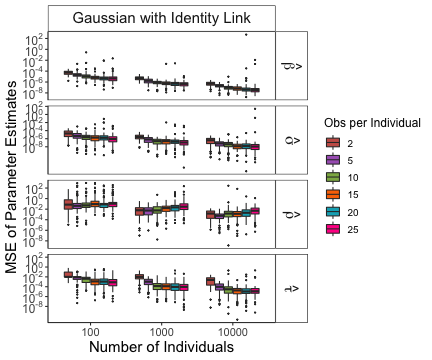

RObject{VecSxp}


In [22]:
### working on figure next
@rput mse_df

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(mse_df)

msedfR[parameters == "beta",y_min := 10^-4]
msedfR[parameters == "beta",y_max := 10^-2]
msedfR[parameters == "sigma",y_min := 10^-5]
msedfR[parameters == "sigma",y_max := 10^1]
msedfR[parameters == "rho",y_min := 10^-5]
msedfR[parameters == "rho",y_max := 10^-2]
msedfR[parameters == "tau",y_min := 10^-5]
msedfR[parameters == "tau",y_max := 10^2]


msedfR$obssize = factor(msedfR$obssize, levels = c('2', '5', '10', '15', '20', '25'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('100', '1000', '10000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'sigma', 'rho', 'tau'), labels = c(beta = expression(hat(bold(beta))), Sigma = expression(hat(bold(sigma))[]), rho = expression(hat(bold(rho))), tau = expression(hat(bold(tau)))))
msedfR$robust = factor(msedfR$labels, levels = c('Gaussian with Identity Link'),
    labels = c(expression(paste("Gaussian with Identity Link")))) # , expression(paste("MvT Gamma Inverse-Gamma"))))



mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  geom_boxplot(outlier.size = 0.25) +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=11),
        axis.text.y = element_text(angle=0, size=12), axis.title.x = element_text(size = 15), 
        axis.title.y = element_text(size = 15), legend.title = element_text(size = 12),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=10), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(size=15, face="bold"),
        strip.text.x = element_text(size=15)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-8, 8, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Number of Individuals", y = "MSE of Parameter Estimates", fill = "Obs per Individual") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 

"""

In [23]:
R"""
ggsave('updated_msefacetplot_Normal_AR.png', mseplot, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "updated_msefacetplot_Normal_AR.png"
